# GRO620 - Problématique

Voici le fichier de départ de la problématique. Si tout a été installé correctement, vous devriez voir apparaître la première image (DSCF8010.jpeg).

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import string

import random as rng
rng.seed(12345)

print("GRO620 - Problématique")
print("OpenCV version", cv2.__version__)

%matplotlib inline

GRO620 - Problématique
OpenCV version 4.0.1


In [25]:
## Si vous utilisez Google Colab, vous devez d'abord monter votre Google Drive
## où se trouve vos données. 
## Commentez les trois lignes suivantes en ajustant le chemin vers votre propre
## dossier :

# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/gro620-e21

## Pour retrouver le chemin depuis Jupyter, vous pouvez utiliser ceci :
# !ls /content/gdrive/MyDrive


In [26]:
images_fn = os.listdir("photos_prob/")
print("%i photo(s) à traiter"%(len(images_fn)))
if (len(images_fn) == 0):
    print("ERREUR! Vérifiez que vous avez bien un dossier photos_prob au même endroit que ce calepin.")
    
images = []

for f in images_fn:
    img = cv2.imread(os.path.join("photos_prob/", f))
    images.append(img)

9 photo(s) à traiter


La prochaine classe détermine le type d'objet qu'on utilise pour représenter une vis dans l'image.

In [177]:
class BoxVis:
    
    def __init__(self, x = 0, y = 0, w = 0, h = 0, theta = 0, length = 0, contour = [], cluster_img = []):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.theta = theta
        self.length = length
        self.contour = contour
        self.cluster_img = cluster_img

Fonction extrayant le cluster de pixels représentant un rectangle avec une vis à l'intérieur.

In [117]:
def extract_cluster_image(image, rec_x, rec_y, rec_w, rec_h):
    return image[ rec_y : rec_y + h, rec_x : rec_x + w]

In [27]:
file_name = 'rapport_vis.csv'
def write_csv(row_id, row_type, row_x, row_y, row_z, row_theta):
    with open(file_name, mode='a') as rapport_vis:
        rapport_writer = csv.writer(rapport_vis, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

        rapport_writer.writerow(['id', 'Type', 'X (m)', 'Y (m)', 'Z (m)', 'Theta (rad)'])

        rapport_writer.writerow([row_id, row_type, row_x, row_y, row_z, row_theta])
        rapport_vis.close()
        
def clear_csv_file():
    f = open(file_name, "w+")
    f.close()
    

Le prochain code sert à déterminer quelles valeurs de threshold en hsv on va devoir utiliser en upper et lower. 

### Pour quitter la boucle il faut appuyer sur "q"

In [49]:
def nothing(nothing):
    pass

# Load in image
image = images[8].copy()

# Create a window
cv2.namedWindow('image')

# create trackbars for color change
cv2.createTrackbar('HMin','image',0,179,nothing) # Hue is from 0-179 for Opencv
cv2.createTrackbar('SMin','image',0,255,nothing)
cv2.createTrackbar('VMin','image',0,255,nothing)
cv2.createTrackbar('HMax','image',0,179,nothing)
cv2.createTrackbar('SMax','image',0,255,nothing)
cv2.createTrackbar('VMax','image',0,255,nothing)

# Set default value for MAX HSV trackbars.
cv2.setTrackbarPos('HMax', 'image', 179)
cv2.setTrackbarPos('SMax', 'image', 255)
cv2.setTrackbarPos('VMax', 'image', 255)

# Initialize to check if HSV min/max value changes
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

output = image
wait_time = 33

while(1):

    # get current positions of all trackbars
    hMin = cv2.getTrackbarPos('HMin','image')
    sMin = cv2.getTrackbarPos('SMin','image')
    vMin = cv2.getTrackbarPos('VMin','image')

    hMax = cv2.getTrackbarPos('HMax','image')
    sMax = cv2.getTrackbarPos('SMax','image')
    vMax = cv2.getTrackbarPos('VMax','image')

    # Set minimum and max HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Create HSV Image and threshold into a range.
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    output = cv2.bitwise_and(image,image, mask= mask)

    # Print if there is a change in HSV value
    if( (phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display output image
    cv2.imshow('image',output)

    # Wait longer to prevent freeze for videos.
    if cv2.waitKey(wait_time) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

Géométrie du problème:

In [29]:
Tc = np.array([[1,  0,  0,   0.5],
               [0, -1,  0,   0.2],
               [0,  0, -1, 0.282],
               [0,  0,  0,     1]])

f  = 0.023    #m
Cx = 0.0234   #m
Cy = 0.0156   #m
H  = 427      #px
W  = 640      #px

K = np.array([[f,  0,  Cx, 0],
              [0,  f,  Cy, 0],
              [0,  0,   1, 0],
              [0,  0,   0, 1]])

P = np.dot(K, Tc)

Initialisation du CSV et on montre les images de base ici.

In [30]:
clear_csv_file()

for i in range(len(images)):
    write_csv("Image" + str(i), "?", 0, 0, 0, 0)


In [165]:
def find_duplicate_img(x, y, w, h, screw_to_compare):
    if x == screw_to_compare.x:
        if y == screw_to_compare.y:
            return True
    
    return False

Le pipeline principale de traitement d'image suit:

Contours found: 11
Contours found: 10
Contours found: 11
Contours found: 11
Contours found: 10
Contours found: 10
Contours found: 9
Contours found: 10
Contours found: 11


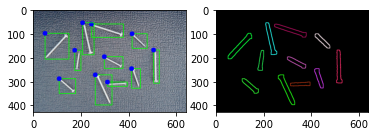

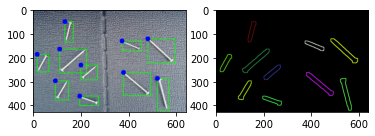

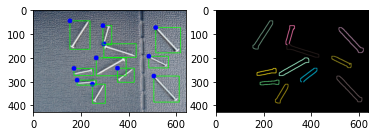

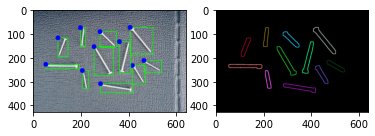

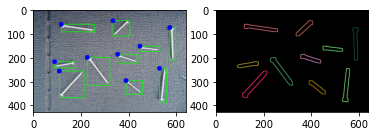

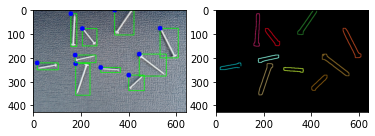

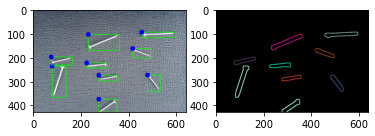

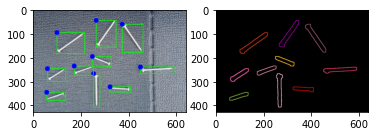

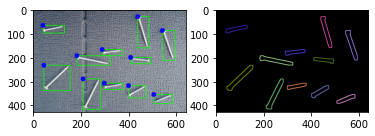

<Figure size 432x288 with 0 Axes>

In [180]:
good_images_screws = []

for j in range(len(images)):
    img_cop = images[j].copy()
    
    hsv = cv2.cvtColor(img_cop, cv2.COLOR_RGB2HSV)
    lower = np.array([0, 0, 235], np.uint8)
    upper = np.array([179, 255, 255], np.uint8)
    mask = cv2.inRange(hsv, lower, upper)
    res = cv2.bitwise_and(img_cop, img_cop, mask = mask)
    
    res_bgr = cv2.cvtColor(res, cv2.COLOR_HSV2BGR)
    kernel = np.ones((6, 6), np.uint8)
    dilation = cv2.dilate(res_bgr, kernel, iterations = 2)
    
    blur_img = cv2.GaussianBlur(dilation, (15, 15), 0)

    img_canny = cv2.Canny(blur_img, 200, 350)
    
    # Find contours
    contours, hierarchy = cv2.findContours(img_canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    good_contours = [] # liste des contours a garder
    good_screws = []

    if len(contours) != 0:
        rectangle = img_cop
        same_img_found = 0
        too_litle_screw_found = 0
        for l in range(len(contours)):
            x, y, w, h = cv2.boundingRect(contours[l])
            
            if l > 0 and (l - same_img_found - too_litle_screw_found - 1) >= 0:
                if find_duplicate_img(x, y, w, h, good_screws[l - same_img_found - too_litle_screw_found - 1]):
                    same_img_found += 1
                    continue

            length = np.sqrt(w**2 + h**2)
            if (length > 50):
                cluster_img = extract_cluster_image(img_canny, x, y, w, h)
                good_screws.append(BoxVis(x, y, w, h, 0, length, contours[l], cluster_img))
                good_contours.append(contours[l])
                rectangle = cv2.rectangle(rectangle, (x, y), (x + w, y + h), (0, 255, 0), 2)
                rectangle = cv2.circle(rectangle, (x, y), radius=10, color=(0, 0, 255), thickness=-1)
            else:
                too_litle_screw_found += 1
        print("Contours found: " + str(len(good_contours)))
    else:
        print("No contour found.")
        continue
    
    good_images_screws.append(good_screws)

    # Draw contours    
    drawing = np.zeros((img_canny.shape[0], img_canny.shape[1], 3), dtype=np.uint8)
    for k in range(len(good_contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv2.drawContours(drawing, good_contours, k, color, 2, cv2.LINE_8, hierarchy, 0)
        
    plt.subplot(121), plt.imshow(rectangle)
    plt.subplot(122), plt.imshow(drawing, cmap="gray")
    plt.figure()

Pipeline maths pour trouver les infos sur les types de vis.

In [181]:
for j in range(len(good_images_screws[:])):
    for i in range(len(good_images_screws[j][:])):

        font = cv2.FONT_HERSHEY_SIMPLEX
        img_copy = good_images_screws[j][i].cluster_img.copy()
        lines = cv2.HoughLines(good_images_screws[j][i].cluster_img, 1, np.pi / 180, 45, None, 0, 0)
        if lines is not None:
            tot_rho = 0
            tot_theta = 0
            for k in range(0, len(lines)):
                rho = lines[k][0][0]
                tot_rho += rho
                theta = lines[k][0][1]
                tot_theta += theta
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
                pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
                cv2.line(img_copy, pt1, pt2, (255,255,255), 3, cv2.LINE_AA)
            mean_theta = tot_theta/len(lines)
            angle = 270-np.degrees(mean_theta)
            if (angle>180):
                angle -= 180
            good_images_screws[j][i].theta = angle
      
        '''plt.subplot(121), plt.imshow(good_images_screws[j][i].cluster_img)
        plt.subplot(122), plt.imshow(img_copy)
        plt.figure()  '''